In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
import logging
logging.basicConfig(level=logging.ERROR)
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!cp "/content/drive/MyDrive/Information_retrieval_project/khan_acad/train_khan_acad.csv" /content
!cp "/content/drive/MyDrive/Information_retrieval_project/khan_acad/test_khan_acad.csv" /content
!cp "/content/drive/MyDrive/Information_retrieval_project/khan_acad/val_khan_acad.csv" /content


In [4]:
!pip install transformers==3.2.0

In [5]:
!pip install git+https://github.com/geoopt/geoopt.git
! pip install git+https://github.com/ferrine/hyrnn.git

  Cloning https://github.com/geoopt/geoopt.git to /tmp/pip-req-build-1zebr962
  Running command git clone -q https://github.com/geoopt/geoopt.git /tmp/pip-req-build-1zebr962
  Created wheel for geoopt: filename=geoopt-0.3.1-cp37-none-any.whl size=76168 sha256=77a2628e178e909b4dc26aa375f749ab9606243f84ccdcfac1b0923625df723e
  Stored in directory: /tmp/pip-ephem-wheel-cache-1wk0pqdr/wheels/10/df/30/e0d857f034c142ca5f38af048b62aae3da773b272553e5dd21
Successfully built geoopt
  Cloning https://github.com/ferrine/hyrnn.git to /tmp/pip-req-build-pdqsjfaz
  Running command git clone -q https://github.com/ferrine/hyrnn.git /tmp/pip-req-build-pdqsjfaz
  Created wheel for hyrnn: filename=hyrnn-0.0.0-cp37-none-any.whl size=13955 sha256=32f84dc379d93592452a0be7d1e4ed094e974f18cfb4997204b087d7a4403109
  Stored in directory: /tmp/pip-ephem-wheel-cache-d9d4wc1f/wheels/24/c3/64/cc0e9d25d466081dc154a2a8843157f54d845b916b4ba66418
Successfully built hyrnn


In [6]:
import pandas as pd
train_data = pd.read_csv("train_khan_acad.csv")
val_data = pd.read_csv("val_khan_acad.csv")
test_data = pd.read_csv("test_khan_acad.csv")

train_data


,video_transcripts,hierarchy
0,In the last couple of videos we saw that we c...,math>>multivariable-calculus>>multivariable-de...
1,- What we're going to do in this video is gi...,science>>ap-biology>>natural-selection
2,"So once again, we have three equal, or we say...",math>>pre-algebra>>pre-algebra-equations-expre...
3,- Liz's math test included a survey question...,math>>engageny-alg-1>>alg1-2
4,- The following two equations form a linear s...,math>>algebra-home>>alg-system-of-equations
...,...,...
4183,- Hello everyone. So this is what I might ca...,math>>multivariable-calculus>>multivariable-de...
4184,- Let's try now to subtract some two-digit n...,math>>early-math>>cc-early-math-add-sub-100
4185,- Let's say that I have a circle. My best att...,math>>engageny-geo>>geo-5
4186,- So let's look at the female reproductive cy...,science>>health-and-medicine>>human-anatomy-an...


In [7]:
from google.colab import files

In [8]:
import re
def clean_sentence(question):
  # print(question)
  question = re.sub('<[^>]*>', ' ',question)
  question = re.sub(' +', ' ', question)
  question = re.sub('\xa0','',question)
  question = question.rstrip()
  question = re.sub('nan','',question)
  question = re.sub(u'\u2004','',question)
  question = re.sub(u'\u2009','',question)

  # question = question.decode("utf-8")
  # question = question.replace(u'\u200\d*','').encode("utf-8")
  question = re.sub('&nbsp','',question)
  question = re.sub('&ndash','',question)
  question = re.sub('\r','',question)
  question = re.sub('\t','',question)
  question = re.sub('\n',' ',question)

  question = re.sub('MathType@.*','',question)
  question = re.sub('&thinsp','',question)
  question = re.sub('&times','',question)
  question = re.sub('\u200b','',question)
  question = re.sub('&rarr;;;','',question)

  return question

In [9]:
!cp -r "/content/drive/My Drive/Information_retrieval_project/model_hyperIM_khan_acad/" /content/

cp: cannot stat '/content/drive/My Drive/Information_retrieval_project/model_hyperIM_khan_acad/': No such file or directory


In [10]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [11]:
train_data["hierarchy"].value_counts()

science>>health-and-medicine>>circulatory-system-diseases     99
science>>health-and-medicine>>human-anatomy-and-physiology    65
science>>health-and-medicine>>respiratory-system-diseases     55
science>>health-and-medicine>>circulatory-system              54
science>>health-and-medicine>>infectious-diseases             52
                                                              ..
math>>5th-engage-ny>>engage-5th-module-1                       1
math>>engageny-geo>>geo-3                                      1
math>>in-in-grade-12-ncert>>in-in-relations-functions          1
math>>precalculus>>x9e81a4f98389efdf:vectors                   1
math>>cc-fourth-grade-math>>4th-multiply-fractions             1
Name: hierarchy, Length: 569, dtype: int64

In [12]:
test_data["hierarchy"].value_counts()

science>>health-and-medicine>>human-anatomy-and-physiology                         24
science>>health-and-medicine>>circulatory-system-diseases                          22
science>>health-and-medicine>>circulatory-system                                   17
science>>electrical-engineering>>robots                                            11
science>>health-and-medicine>>infectious-diseases                                  11
                                                                                   ..
math>>8th-engage-ny>>engage-8th-module-2                                            1
math>>in-in-class-5th-math-cbse>>x91a8f6d2871c8046:imp-place-value-and-decimals     1
science>>biology>>photosynthesis-in-plants                                          1
math>>algebra>>x2f8bb11595b61c86:quadratics-multiplying-factoring                   1
math>>differential-equations>>first-order-differential-equations                    1
Name: hierarchy, Length: 416, dtype: int64

In [13]:

from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
LE.fit_transform(pd.concat([train_data['hierarchy'],test_data['hierarchy']]))
train_data['label'] = LE.transform(train_data['hierarchy'])
train_data.head()

,video_transcripts,hierarchy,label
0,In the last couple of videos we saw that we c...,math>>multivariable-calculus>>multivariable-de...,354
1,- What we're going to do in this video is gi...,science>>ap-biology>>natural-selection,422
2,"So once again, we have three equal, or we say...",math>>pre-algebra>>pre-algebra-equations-expre...,384
3,- Liz's math test included a survey question...,math>>engageny-alg-1>>alg1-2,231
4,- The following two equations form a linear s...,math>>algebra-home>>alg-system-of-equations,99


In [14]:
test_data['label'] = LE.transform(test_data['hierarchy'])
test_data.head()

,video_transcripts,hierarchy,label
0,- What I hope to do in this video is get fam...,math>>math1>>x89d82521517266d4:functions,335
1,In the last video we were able to set up this...,math>>old-ap-calculus-ab>>ab-applications-defi...,357
2,- In previous videos we talk about GDP as th...,economics-finance-domain>>ap-macroeconomics>>e...,3
3,- So what we're gonna do in this video is se...,math>>old-integral-calculus>>definite-integral...,378
4,- So I've said that if you have a vector fie...,math>>multivariable-calculus>>multivariable-de...,354


In [15]:
val_data['label'] = LE.transform(val_data['hierarchy'])
val_data.head()

,video_transcripts,hierarchy,label
0,Find the probability of rolling doubles on tw...,math>>precalculus>>x9e81a4f98389efdf:prob-comb,395
1,"After the food is swallowed, it leaves the m...",science>>health-and-medicine>>human-anatomy-an...,497
2,Let's now talk about what is easily one of th...,math>>geometry>>hs-geo-trig,256
3,The goal in this video is to essentially prov...,science>>chemistry>>thermodynamics-chemistry,472
4,"A line goes through the points (-1, 6) and (5...",math>>in-in-grade-11-ncert>>in-in-class11-stra...,304


In [16]:
def get_labels(prediction):
    predicted_label =  LE.inverse_transform([prediction])
    return predicted_label[0]

In [17]:
get_labels(571)

'science>>physics>>work-and-energy'

In [18]:
get_labels(204)

'math>>cc-seventh-grade-math>>cc-7th-fractions-decimals'

In [19]:
train_data.iloc[14,1]

'economics-finance-domain>>macroeconomics>>monetary-system-topic'

In [20]:
train_data

,video_transcripts,hierarchy,label
0,In the last couple of videos we saw that we c...,math>>multivariable-calculus>>multivariable-de...,354
1,- What we're going to do in this video is gi...,science>>ap-biology>>natural-selection,422
2,"So once again, we have three equal, or we say...",math>>pre-algebra>>pre-algebra-equations-expre...,384
3,- Liz's math test included a survey question...,math>>engageny-alg-1>>alg1-2,231
4,- The following two equations form a linear s...,math>>algebra-home>>alg-system-of-equations,99
...,...,...,...
4183,- Hello everyone. So this is what I might ca...,math>>multivariable-calculus>>multivariable-de...,354
4184,- Let's try now to subtract some two-digit n...,math>>early-math>>cc-early-math-add-sub-100,226
4185,- Let's say that I have a circle. My best att...,math>>engageny-geo>>geo-5,240
4186,- So let's look at the female reproductive cy...,science>>health-and-medicine>>human-anatomy-an...,497


In [21]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_data["video_transcripts"],test_data["video_transcripts"],train_data["label"],test_data["label"]
val_features,val_labels = val_data["video_transcripts"], val_data["label"]

In [22]:
train_labels.value_counts()

489    99
497    65
505    55
488    54
498    52
       ..
382     1
359     1
195     1
471     1
216     1
Name: label, Length: 569, dtype: int64

In [23]:
test_labels.value_counts()

497    24
489    22
488    17
93     11
485    11
       ..
192     1
191     1
398     1
187     1
291     1
Name: label, Length: 416, dtype: int64

In [24]:
question_answer = train_features.values
categories = train_labels.values

In [25]:
question_answer

array([" In the last couple of videos we saw that we can describe a curves by a position vector-valued function. And in very general terms, it would be the x position as a function of time times the unit vector in the horizontal direction. Plus the y position as a function of time times the unit victor in the vertical direction. And this will essentially describe this-- though, if you can imagine a particle and let's say the parameter t represents time. It'll describe where the particle is at any given time. And if we wanted a particular curve we can say, well, this only applies for some curve-- we're dealing, it's r of t. And it's only applicable between t being greater than a and less than b. And you know, that would describe some curve in two dimensions. Just me just draw it here. This is all a review of really, the last two videos. So this curve, it might look something like that where this is where t is equal to a. That's where t is equal to b. And so r of a will be this vector ri

In [26]:
categories

array([354, 422, 384, ..., 240, 497, 352])

In [27]:
# this method can be used to project from euclidean space to hyperbolic space
def exponential_map(vector):
        norm_v = np.linalg.norm(vector, axis=1)
        coef = np.tanh(norm_v) / norm_v
        second_term = vector * coef[:, None]
        return second_term

In [28]:
# this method can be used to project from euclidean space to hyperbolic space
def tensor_exponential_map(vector):
      vector_norm = vector.norm(dim=-1, p=2, keepdim=True).clamp_min(1e-15)
      gamma_1 = torch.nn.functional.tanh(vector_norm) * (vector / vector_norm)
      return gamma_1

In [29]:
def tensor_log_map(vector):
      vector_norm = vector.norm(dim=-1, p=2, keepdim=True).clamp_min(1e-15)
      gamma_1 = torch.atanh(vector_norm) * (vector / vector_norm)
      return gamma_1

In [30]:

import numpy as np

from bokeh.io import output_file, output_notebook, show
from bokeh.plotting import figure
from bokeh.transform import linear_cmap
from bokeh.util.hex import hexbin
from bokeh.models import HoverTool
from bokeh import colors

from gzip import open as gopen

import gensim.models.poincare as poincare
poincare_model = poincare.PoincareModel.load("taxonomy_khan_acad_embedding_20.pkl")
def get_poincare_embeddings_data(taxonomy):
  cleaned_taxonomy = []
  for value in taxonomy:
      value = value.split(">>")
      cleaned_taxonomy.append( list(tok.lower() for tok in value) )
  return cleaned_taxonomy

In [31]:

# course_taxonomy


# course_taxonomy

poincare_emb_data_train = get_poincare_embeddings_data(train_data["hierarchy"].values)
poincare_emb_data_val = get_poincare_embeddings_data(val_data["hierarchy"].values)

In [32]:
poincare_embedding_train =  [exponential_map(np.expand_dims( np.hstack(  [ poincare_model.kv.get_vector(str(x)) for x in taxonomy ] ),axis=0)) for taxonomy in poincare_emb_data_train ]
np.linalg.norm(poincare_embedding_train[1000])

0.899765215781272

In [33]:
poincare_embedding_val=  [exponential_map(np.expand_dims( np.hstack(  [ poincare_model.kv.get_vector(str(x)) for x in taxonomy ] ),axis=0)) for taxonomy in poincare_emb_data_val ]
np.linalg.norm(poincare_embedding_val[100])

0.8857759138716806

In [34]:
max_val_train = 0
max_emb =None
for embedding in poincare_embedding_train:
  val = embedding.shape[1]
  if val >max_val_train:
    max_val_train=val
    max_emb =embedding
max_val_train


60

In [35]:
max_val_val = 0
max_emb =None
for embedding in poincare_embedding_val:
  val = embedding.shape[1]
  if val >max_val_train:
    max_val_val=val
    max_emb =embedding
max_val_val


0

In [36]:
len(set(categories))

569

In [37]:
def get_concat_embedding(poincare_embedding,max_val):
  concatenated_embedding = []
  for embedding in poincare_embedding:
    if embedding.shape[1] < max_val:
      new_embedding = np.append(embedding, np.expand_dims(np.zeros(max_val-embedding.shape[1]),axis=0),axis=1)
    else:
      new_embedding = embedding
    concatenated_embedding.append(np.squeeze(new_embedding,axis=0))
  return concatenated_embedding



In [38]:
concat_embedding_train = get_concat_embedding(poincare_embedding_train,max_val_train)
concat_embedding_val = get_concat_embedding(poincare_embedding_val,max_val_train)

In [39]:
poincare_embeddings_final_train = np.stack(concat_embedding_train, axis=0)
poincare_embeddings_final_train.shape

(4188, 60)

In [40]:
poincare_embeddings_final_val = np.stack(concat_embedding_val, axis=0)
poincare_embeddings_final_val.shape

(924, 60)

In [41]:
input_ids = []
attention_masks = []

for sent in question_answer:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        truncation=True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)


# Print sentence 0, now as a list of IDs.
print('Original: ', question_answer[0])
print('Token IDs:', input_ids[0])

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:   In the last couple of videos we saw that we can describe a curves by a position vector-valued function. And in very general terms, it would be the x position as a function of time times the unit vector in the horizontal direction. Plus the y position as a function of time times the unit victor in the vertical direction. And this will essentially describe this-- though, if you can imagine a particle and let's say the parameter t represents time. It'll describe where the particle is at any given time. And if we wanted a particular curve we can say, well, this only applies for some curve-- we're dealing, it's r of t. And it's only applicable between t being greater than a and less than b. And you know, that would describe some curve in two dimensions. Just me just draw it here. This is all a review of really, the last two videos. So this curve, it might look something like that where this is where t is equal to a. That's where t is equal to b. And so r of a will be this vector

In [42]:
input_ids_val = []
attention_masks_val = []

for sent in val_features:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        truncation=True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids_val.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks_val.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids_val = torch.cat(input_ids_val, dim=0)
attention_masks_val = torch.cat(attention_masks_val, dim=0)


# Print sentence 0, now as a list of IDs.
print('Original: ', question_answer[0])
print('Token IDs:', input_ids[0])

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:   In the last couple of videos we saw that we can describe a curves by a position vector-valued function. And in very general terms, it would be the x position as a function of time times the unit vector in the horizontal direction. Plus the y position as a function of time times the unit victor in the vertical direction. And this will essentially describe this-- though, if you can imagine a particle and let's say the parameter t represents time. It'll describe where the particle is at any given time. And if we wanted a particular curve we can say, well, this only applies for some curve-- we're dealing, it's r of t. And it's only applicable between t being greater than a and less than b. And you know, that would describe some curve in two dimensions. Just me just draw it here. This is all a review of really, the last two videos. So this curve, it might look something like that where this is where t is equal to a. That's where t is equal to b. And so r of a will be this vector

In [43]:
num_classes = len(list(set(categories)))
num_classes

569

In [44]:
num_classes

569

In [45]:
from torch.utils.data import TensorDataset, random_split
# train_poincare_tensor = torch.tensor(poincare_embeddings_final,dtype=torch.float)
train_poincare_tensor = torch.tensor(poincare_embeddings_final_train,dtype=torch.float)
val_poincare_tensor = torch.tensor(poincare_embeddings_final_val, dtype=torch.float)
train_labels = torch.tensor(categories)
val_labels = torch.tensor(val_labels.values)
# Combine the training inputs into a TensorDataset.
train_dataset = TensorDataset(input_ids, attention_masks,train_poincare_tensor, train_labels)
val_dataset = TensorDataset(input_ids_val,attention_masks_val,val_poincare_tensor,val_labels)
# Create a 80-20train-validation split.

# # Calculate the number of samples to include in each set.
# train_size = int(0.90 * len(dataset))
# val_size = len(dataset) - train_size

# # Divide the dataset by randomly selecting samples.
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# print('{:>5,} training samples'.format(train_size))
# print('{:>5,} validation samples'.format(val_size))

In [46]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
batch_size = 32
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), 
            batch_size = batch_size 
        )

In [47]:
import numpy as np
from torch.autograd import Function
class Distance(Function):
    @staticmethod
    def grad(x, v, sqnormx, sqnormv, sqdist, eps):
        alpha = (1 - sqnormx)
        beta = (1 - sqnormv)
        z = 1 + 2 * sqdist / (alpha * beta)
        a = ((sqnormv - 2 * torch.sum(x * v, dim=-1) + 1) / torch.pow(alpha, 2))\
            .unsqueeze(-1).expand_as(x)
        a = a * x - v / alpha.unsqueeze(-1).expand_as(v)
        z = torch.sqrt(torch.pow(z, 2) - 1)
        z = torch.clamp(z * beta, min=eps).unsqueeze(-1)
        return 4 * a / z.expand_as(x)

    @staticmethod
    def forward(ctx, u, v, eps):
        squnorm = torch.clamp(torch.sum(u * u, dim=-1), 0, 1 - eps)
        sqvnorm = torch.clamp(torch.sum(v * v, dim=-1), 0, 1 - eps)
        sqdist = torch.sum(torch.pow(u - v, 2), dim=-1)
        ctx.eps = eps
        ctx.save_for_backward(u, v, squnorm, sqvnorm, sqdist)
        x = sqdist / ((1 - squnorm) * (1 - sqvnorm)) * 2 + 1
        # arcosh
        z = torch.sqrt(torch.pow(x, 2) - 1)
        return torch.log(x + z)

    @staticmethod
    def backward(ctx, g):
        u, v, squnorm, sqvnorm, sqdist = ctx.saved_tensors
        g = g.unsqueeze(-1)
        gu = Distance.grad(u, v, squnorm, sqvnorm, sqdist, ctx.eps)
        gv = Distance.grad(v, u, sqvnorm, squnorm, sqdist, ctx.eps)
        return g.expand_as(gu) * gu, g.expand_as(gv) * gv, None
def distanceTo(vector1,vector2):
        return Distance.apply(vector1,vector2,1e-5)
        # vector1 = vector1.detach().cpu().numpy()
        # vector2 = vector2.detach().cpu().numpy()
        # euclidean_dists = np.linalg.norm(vector1 - vector2)  
        # gamma = 1 + 2 * ((euclidean_dists ** 2) / ((1-(np.linalg.norm(vector1))) * (1-np.linalg.norm(vector2))))  # (1 + neg_size, batch_size)
        # poincare_dists = np.arccosh(gamma) 
        # return torch.tensor(poincare_dists,dtype=torch.float)

In [48]:
import sys
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from matplotlib import pyplot as plt
from torch.nn.modules.loss import HingeEmbeddingLoss
from random import randint
import geoopt.manifolds.stereographic.math as pm
import geoopt.optim.rsgd as rsgd_
import geoopt.optim.radam as radam_
# from hyrnn.nets import MobiusLinear
from geoopt.tensor import ManifoldParameter
from geoopt.manifolds.stereographic import PoincareBall
from tqdm import tqdm
import geoopt
import time
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from matplotlib import pyplot as plt
from torch.nn.modules.loss import HingeEmbeddingLoss
from random import randint
import geoopt.optim.rsgd as rsgd_
import geoopt.optim.radam as radam_
# from hyrnn.nets import MobiusLinear
from geoopt.tensor import ManifoldParameter
import time
import argparse
cos = nn.CosineSimilarity(dim=0, eps=1e-6)

def create_ball(ball=None, c=None):
    """
    Helper to create a PoincareBall.
    Sometimes you may want to share a manifold across layers, e.g. you are using scaled PoincareBall.
    In this case you will require same curvature parameters for different layers or end up with nans.
    Parameters
    ----------
    ball : geoopt.PoincareBall
    c : float
    Returns
    -------
    geoopt.PoincareBall
    """
    if ball is None:
        assert c is not None, "curvature of the ball should be explicitly specified"
        ball = geoopt.PoincareBall(c)
    # else trust input
    return ball


class MobiusLinear(torch.nn.Linear):
    def __init__(self, *args, nonlin=None, ball=None, c=1.0, **kwargs):
        super().__init__(*args, **kwargs)
        # for manifolds that have parameters like Poincare Ball
        # we have to attach them to the closure Module.
        # It is hard to implement device allocation for manifolds in other case.
        self.ball = create_ball(ball, c)
        if self.bias is not None:
            self.bias = geoopt.ManifoldParameter(self.bias, manifold=self.ball)
        self.nonlin = nonlin
        self.reset_parameters()

    def forward(self, input):
        return mobius_linear(
            input,
            weight=self.weight,
            bias=self.bias,
            nonlin=self.nonlin,
            ball=self.ball,
        )

    @torch.no_grad()
    def reset_parameters(self):
        torch.nn.init.eye_(self.weight)
        self.weight.add_(torch.rand_like(self.weight).mul_(1e-3))
        if self.bias is not None:
            self.bias.zero_()


# package.nn.functional.py
def mobius_linear(input, weight, bias=None, nonlin=None, *, ball: geoopt.PoincareBall):
    output = ball.mobius_matvec(weight, input)
    if bias is not None:
        output = ball.mobius_add(output, bias)
    if nonlin is not None:
        output = ball.logmap0(output)
        output = nonlin(output)
        output = ball.expmap0(output)
    return output
# Neural Classifierwork
class MulticlassClassifier(nn.Module):
    def __init__(self,bert_model_path):
        super(MulticlassClassifier,self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_path,output_hidden_states=True,output_attentions=False)
        self.dropout = nn.Dropout(0.1)
        self.fc1 = MobiusLinear(768, 384)
        self.fc2 = MobiusLinear(384, 60)

    def forward(self,tokens,masks):
        _, pooled_output,hidden = self.bert(tokens, attention_mask=masks)
        hyerbolic_transform = tensor_exponential_map(hidden[12])
        x = self.fc1(hyerbolic_transform)
        x = self.fc2(x)
        return x

class MyHingeLoss(torch.nn.Module):
    def __init__(self, margin):
        super(MyHingeLoss, self).__init__()
        self.margin = margin


    def forward(self, output, target):
        loss = 0
        for i in range(len(output)):
            text_emb = output[i]
            t_label = target[i]
            j = randint(0, len(output)-1)
            while j == i:
                j = randint(0, len(output)-1)
            t_j = target[j]
            loss += torch.relu( self.margin + \
                            distanceTo(t_label, text_emb) - distanceTo(t_j, text_emb) )
        return loss / len(output)

class MyHingeLoss_cos(torch.nn.Module):

    def __init__(self, margin):
        super(MyHingeLoss_cos, self).__init__()
        self.margin = margin

    def forward(self, output, target):
        loss = 0
        for i in range(len(output)):
            text_emb = output[i]
            t_label = target[i]
            j = randint(0, len(output)-1)
            while j == i:
                j = randint(0, len(output)-1)
            t_j = target[j]
            loss += torch.relu( self.margin - cos(t_label, text_emb) + cos(t_j, text_emb) )
        return loss / len(output)

In [49]:
from transformers import BertModel, AdamW, BertConfig


In [50]:
def dist_without_grad( u, v):
  sqdist = torch.sum((u - v) ** 2, dim=-1)
  squnorm = torch.sum(u ** 2, dim=-1)
  sqvnorm = torch.sum(v ** 2, dim=-1)
  x = 1 + 2 * sqdist / ((1 - squnorm) * (1 - sqvnorm)) + 1e-7
  z = torch.sqrt(x ** 2 - 1)
  return torch.log(x + z)

In [51]:
class FinalClassifier(nn.Module):
    def __init__(self,bert_model_path):
        super(FinalClassifier,self).__init__()
        self.model2 = MulticlassClassifier(bert_model_path)
        # self.model2.load_state_dict(torch.load('model_hyperbolic_round_2/model_weights'))
        self.dropout = nn.Dropout(0.1)
        self.i =0
        for param in self.model2.parameters():
            param.requires_grad = True
        self.mlp = nn.Sequential(
            nn.Linear(896 , 400),
            nn.ReLU(),
            # nn.Linear(mlp_dim, mlp_dim),
            # nn.ReLU(),
            # nn.Linear(mlp_dim, mlp_dim),
            # nn.ReLU(),            
            nn.Linear(400, 572))

    def forward(self,tokens,masks,poincare_tensor):
        output = self.model2.bert(tokens,masks)
        hierarch_output = self.model2(tokens,masks)
        similarity_vector = 1/(1+dist_without_grad(hierarch_output,poincare_tensor.unsqueeze(axis=1)))
        # if self.i ==0:
        #   print("similarity_vector",similarity_vector.shape)

        concat_output = torch.cat((output[1],similarity_vector),dim=1)
        # output_1 = tensor_log_map(output)
        # word_emb = output[2][-1]
        # word_embeddings = 
        concat_out = self.dropout(concat_output)
        x = self.mlp(concat_out)
        return x
model = FinalClassifier('bert-base-uncased')
model.cuda()

FinalClassifier(
  (model2): MulticlassClassifier(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
   

In [52]:
torch.cat((model.model2.bert(input_ids[0:3].to(device),attention_masks[0:3].to(device))[1],1/(1+ dist_without_grad(model.model2(input_ids[0:3].to(device),attention_masks[0:3].to(device)),torch.tensor(poincare_embeddings_final_train[:3]).unsqueeze(axis=1).to(device)))), dim=1)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


tensor([[-0.2034, -0.2628, -0.9288,  ...,  0.1841,  0.1956,  0.2161],
        [-0.8679, -0.5666, -0.9891,  ...,  0.1885,  0.1804,  0.1782],
        [-0.5717, -0.5244, -0.9764,  ...,  0.1830,  0.1922,  0.1883]],
       device='cuda:0', dtype=torch.float64, grad_fn=<CatBackward>)

In [53]:
dist_without_grad(model.model2(input_ids[0:3].to(device),attention_masks[0:3].to(device)),torch.tensor(poincare_embeddings_final_train[:3]).unsqueeze(axis=1).to(device)).shape

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


torch.Size([3, 128])

In [54]:
model.model2(input_ids[0:3].to(device),attention_masks[0:3].to(device)).shape

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


torch.Size([3, 128, 60])

In [55]:
from transformers import BertModel, AdamW, BertConfig

# # Loads BertModel, the pretrained BERT model with a single 
# model = MulticlassClassifier('bert-base-uncased')

# # Tell pytorch to run this model on the GPU.
# model.cuda()


In [56]:
mobius_params = []
bert_params = []

def mobius_params():
  for param in model.named_parameters():
    if 'fc' in param[0]:
      yield param[1]
def bert_params():
  for param in model.named_parameters():
    if 'bert' in param[0]:
      yield param[1]


In [57]:
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
# optimizer_2 = radam_.RiemannianAdam(mobius_params(), lr=0.01, stabilize=10)

In [58]:
from transformers import get_linear_schedule_with_warmup


epochs = 30

# Total number of training steps is [number of batches] x [number of epochs]. 
total_steps = len(train_dataloader) * epochs



In [59]:
len(train_dataloader) 

131

In [60]:
1935 * 32

61920

In [61]:
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [62]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [63]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [64]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


In [65]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [66]:
criterion = nn.CrossEntropyLoss()


In [67]:
import random
import numpy as np
import json
from sklearn.metrics import f1_score
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()
early_stopping = EarlyStopping(patience=4, verbose=True)

# For each epoch...
for epoch_i in range(0, epochs):
    


    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0
    total_train_accuracy=0


    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_poincare = batch[2].to(device)
        b_labels = batch[3].to(device)


        model.zero_grad() 
        optimizer.zero_grad()       
        logits = model(b_input_ids, 
                             b_input_mask,b_poincare)
        # if epoch_i==0:
        #   print(logits)
        
        loss = criterion(logits,b_labels)

  
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()
        # Update the learning rate.
        scheduler.step()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_train_accuracy += flat_accuracy(logits, label_ids)
    avg_train_accuracy = total_train_accuracy / len(train_dataloader)
    print(" Train Accuracy: {0:.2f}".format(avg_train_accuracy))

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_f1 = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_poincare = batch[2].to(device)
        b_labels = batch[3].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        


          logits = model(b_input_ids, 
                              b_input_mask,b_poincare)
          
        loss = criterion(logits,b_labels)

            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_f1 += flat_accuracy(logits,label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_f1 / len(validation_dataloader)
    print("  validation accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    early_stopping(avg_val_loss, model)
    if early_stopping.early_stop:
      print("Early stopping")
      break  
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    output_dir = 'model_hyperIM_khan_acad/'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    print("Saving model to %s" % output_dir)
    tokenizer.save_pretrained(output_dir)
    torch.save(model.state_dict(), os.path.join(output_dir, 'model_weights'))

    !rm -rf "/content/drive/My Drive/Information_retrieval_project/model_hyperIM_khan_acad"
    !mv model_hyperIM_khan_acad "/content/drive/My Drive/Information_retrieval_project/"
    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 30 ========
Training...


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


  Batch    40  of    131.    Elapsed: 0:01:56.
  Batch    80  of    131.    Elapsed: 0:03:49.
  Batch   120  of    131.    Elapsed: 0:05:42.
 Train Accuracy: 0.02

  Average training loss: 6.28
  Training epcoh took: 0:06:14

Running Validation...
  validation accuracy: 0.02
Validation loss decreased (inf --> 6.193237).  Saving model ...
  Validation Loss: 6.19
  Validation took: 0:00:31
Saving model to model_hyperIM_khan_acad/

======== Epoch 2 / 30 ========
Training...
  Batch    40  of    131.    Elapsed: 0:01:54.
  Batch    80  of    131.    Elapsed: 0:03:47.
  Batch   120  of    131.    Elapsed: 0:05:40.
 Train Accuracy: 0.03

  Average training loss: 6.06
  Training epcoh took: 0:06:11

Running Validation...
  validation accuracy: 0.02
Validation loss decreased (6.193237 --> 5.960955).  Saving model ...
  Validation Loss: 5.96
  Validation took: 0:00:30
Saving model to model_hyperIM_khan_acad/

======== Epoch 3 / 30 ========
Training...
  Batch    40  of    131.    Elapsed: 0:01:

In [76]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,6.28,6.19,0:06:14,0:00:31
2,6.06,5.96,0:06:11,0:00:30
3,5.78,5.72,0:06:10,0:00:30
4,5.51,5.53,0:06:12,0:00:30
5,5.27,5.35,0:06:11,0:00:30
6,5.05,5.19,0:06:11,0:00:30
7,4.84,5.07,0:06:12,0:00:30
8,4.66,4.97,0:06:12,0:00:30
9,4.49,4.87,0:06:13,0:00:30


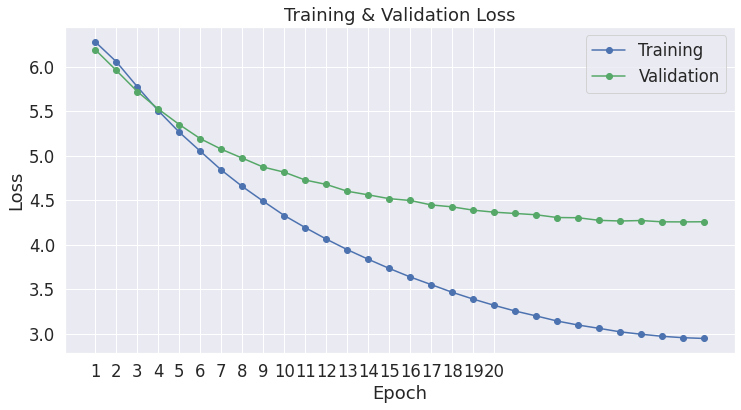

In [77]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])

plt.show()

In [70]:
import os


output_dir = 'model_hyperIM_khan_acad/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)


# model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
# model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to model_hyperIM_khan_acad/


('model_hyperIM_khan_acad/vocab.txt',
 'model_hyperIM_khan_acad/special_tokens_map.json',
 'model_hyperIM_khan_acad/added_tokens.json')

In [71]:
!pip install joblib
import joblib
joblib.dump(LE, "label_encoder")


['label_encoder']

['label_encoder']

['label_encoder']

['label_encoder']

['label_encoder']

In [72]:
import json
torch.save(model.state_dict(), os.path.join(output_dir, 'model_weights'))


In [73]:
# with open(os.path.join(output_dir, 'model_config.json'), 'w') as f:
#     json.dump(model.config, f)

In [74]:
!zip -r model_hyperIM_khan_acad.zip model_hyperIM_khan_acad
# files.download('model_hyperIM_QC.zip')

  adding: model_hyperIM_khan_acad/ (stored 0%)
  adding: model_hyperIM_khan_acad/special_tokens_map.json (deflated 40%)
  adding: model_hyperIM_khan_acad/vocab.txt (deflated 53%)
  adding: model_hyperIM_khan_acad/tokenizer_config.json (stored 0%)
  adding: model_hyperIM_khan_acad/model_weights  adding: model_hyperIM_khan_acad/ (stored 0%)
  adding: model_hyperIM_khan_acad/special_tokens_map.json (deflated 40%)
  adding: model_hyperIM_khan_acad/vocab.txt (deflated 53%)
  adding: model_hyperIM_khan_acad/tokenizer_config.json (stored 0%)
  adding: model_hyperIM_khan_acad/model_weights  adding: model_hyperIM_khan_acad/ (stored 0%)
  adding: model_hyperIM_khan_acad/special_tokens_map.json (deflated 40%)
  adding: model_hyperIM_khan_acad/vocab.txt (deflated 53%)
  adding: model_hyperIM_khan_acad/tokenizer_config.json (stored 0%)
  adding: model_hyperIM_khan_acad/model_weights  adding: model_hyperIM_khan_acad/ (stored 0%)
  adding: model_hyperIM_khan_acad/special_tokens_map.json (deflated 40%

In [78]:
!zip -r label_encoder_hyperIM_khan_acad.zip label_encoder
files.download('label_encoder_hyperIM_khan_acad.zip')
!mv label_encoder_hyperIM_QC.zip "/content/drive/My Drive/Information_retrieval_project/"
!mv model_hyperIM_QC.zip "/content/drive/My Drive/Information_retrieval_project/"

  adding: label_encoder (deflated 76%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

mv: cannot stat 'model_hyperIM_QC.zip': No such file or directory
